# Map of Gordon's Bay - Refactored Version

## For Prodive's Divemaster course

As part of this course, I need to draw a map of a dive site. Being an odd fish, I've got a bit carried away. There's a lot more context in the [readme file](https://github.com/notionparallax/dive-map/blob/main/README.md) in the repo.

Let's get started. If you're just following along for the pictures, ignore all the python (the coloured writing) and go straight to the pictures.

**This is the refactored version** that uses the new modular architecture for better maintainability and reusability.

In [1]:
# pip install -r requirements.txt

In [2]:
# Import standard libraries
import os
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import LineString, MultiPoint, Point, Polygon

# Import our refactored modules
from config import (
    TEXT_COLOUR, CRS, FIGURE_SIZE, GORDONS_BAY_COORDS,
    BOTTOM_CONDITION_COLORS, SHORE_DEPTHS, CONTOUR_SPACING, DEPTH_RANGE
)
from data_loaders import DiveDataProcessor
from visualization import MapRenderer, MarkerRenderer, ContourRenderer
from refactored_functions import (
    make_marker_text, measure_line_string, draw_shortcut_arrow,
    apply_annotations, filter_by_distance
)

# Import existing photo metadata (until we refactor this too)
from photo_meta import photo_meta as pm_1
from photo_meta_day_2 import photo_meta as pm_2
from photo_meta_day_3 import photo_meta as pm_3

# Set matplotlib parameters
plt.rcParams["svg.fonttype"] = "none"

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


In [3]:
# Consolidate photo metadata 
# I've got the photo data as python data, rather than json, not really for any good reason though. 
# It's just a big list of dictionaries. These are made by running img.py on a folder full of photos
photo_meta = pm_1 + pm_2 + pm_3

# Configure data sources - now centralized instead of scattered throughout
fit_files = [
    os.path.join("fit", "ScubaDiving_2024-03-08T09_29_45.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-08T11_26_21.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T08_51_29.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T09_41_59.fit"),
    os.path.join("fit", "ScubaDiving_2024-03-23T11_06_51.fit"),
    os.path.join("fit", "ScubaDiving_2024-05-17T10_33_57.fit"),
    os.path.join("fit", "ScubaDiving_2024-05-24T09_04_22.fit"),
]

# GPX configurations with their specific parameters
gpx_configs = [
    {
        "file_path": os.path.join("gps", "20240308-090746 - Gordons.gpx"),
        "description": "chain_loop",
        "crop": True,
        "end_time": "2024-03-08T02:25:26Z",
        "dive_end_time_delta": 180,
        "dive_start_time_delta": 250,
    },
    {
        "file_path": os.path.join("gps", "20240308-090746 - Gordons.gpx"),
        "description": "boulder_garden",
        "crop": True,
        "end_time": "2024-03-08T02:25:26Z",
        "dive_end_time_delta": 70,
        "dive_start_time_delta": 120,
    },
    {
        "file_path": os.path.join("gps", "20240323-081550 - Map dive Saturday morning.gpx"),
        "description": "wall_to_desert",
        "crop": True,
        "end_time": "2024-03-22 22:52:06+00:00",
        "dive_end_time_delta": 5,
        "dive_start_time_delta": 65,
    },
    {
        "file_path": os.path.join("gps", "20240323-104518 - Dive 2.gpx"),
        "description": "far_side_desert",
        "crop": True,
        "end_time": "2024-03-23 01:14:03.999000+00:00",
        "dive_end_time_delta": 10,
        "dive_start_time_delta": 68,
    },
    {
        "file_path": os.path.join("gps", "20240517-101408 - Map random swim.gpx"),
        "description": "random_swim",
        "crop": False,
    },
    {
        "file_path": os.path.join("gps", "20240524-084346 - Bommie.gpx"),
        "description": "out to the bommie",
        "crop": False,
    },
]

print(f"📊 Configured {len(fit_files)} FIT files and {len(gpx_configs)} GPS tracks")

📊 Configured 7 FIT files and 6 GPS tracks


## Data Loading with New Architecture

The depth data comes from my watch, a Suunto D5, and I export the `.fit` file from the phone app.

Instead of manually loading and combining each data source separately, we now use the `DiveDataProcessor` class to handle all data loading consistently.

In [4]:
# Load all data with the new streamlined approach
processor = DiveDataProcessor()
depth_df, dives_gdf, photo_df = processor.load_all_data(
    fit_files=fit_files,
    gpx_configs=gpx_configs,
    photo_metadata=photo_meta
)

print(f"📈 Loaded data:")
print(f"   • {len(depth_df):,} depth measurements")
print(f"   • {len(dives_gdf):,} GPS positions across {len(dives_gdf.description.unique())} dive tracks")
print(f"   • {len(photo_df):,} photos with metadata")
print(f"   • Date range: {dives_gdf.index.min()} to {dives_gdf.index.max()}")

📈 Loaded data:
   • 2,414 depth measurements
   • 31,805 GPS positions across 6 dive tracks
   • 295 photos with metadata
   • Date range: 2024-03-07 22:15:27+00:00 to 2024-05-24 01:22:12.999000+00:00


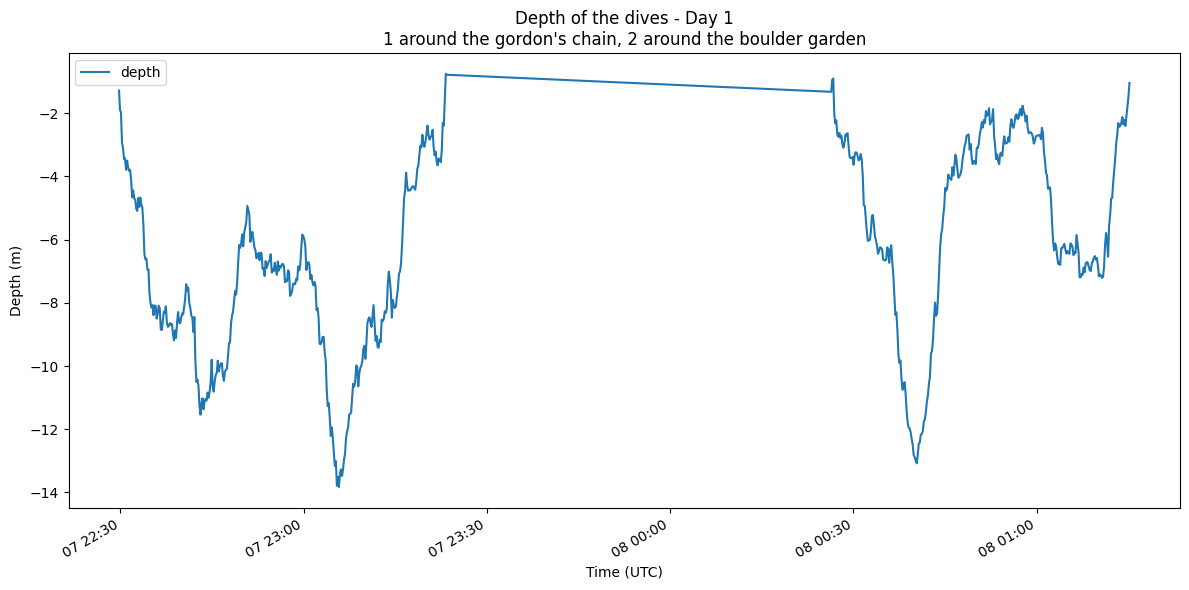

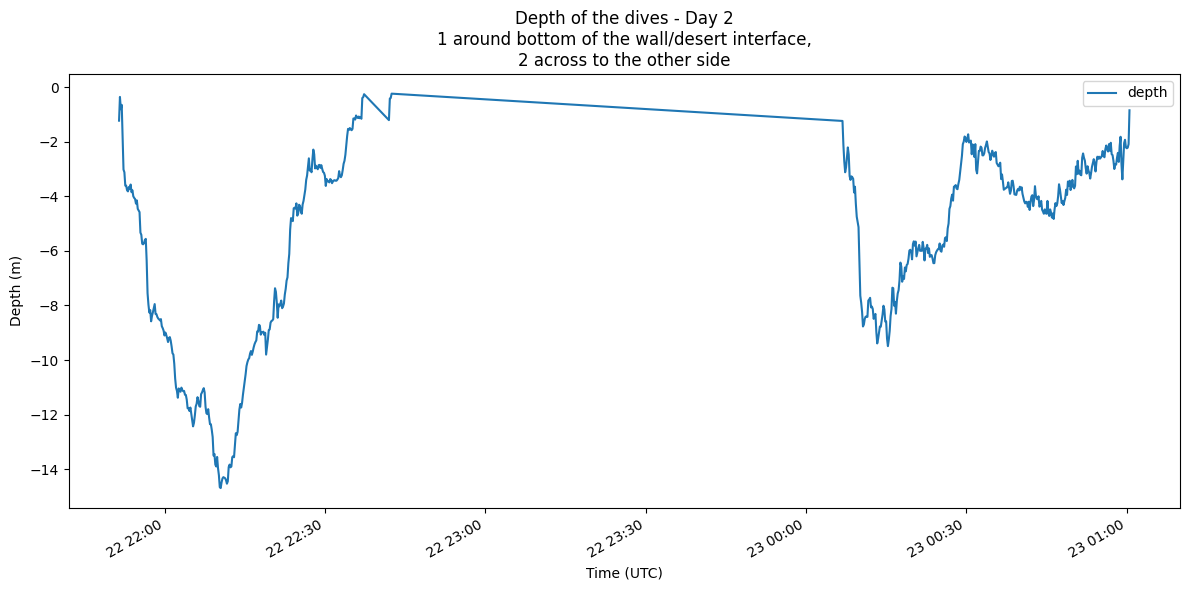

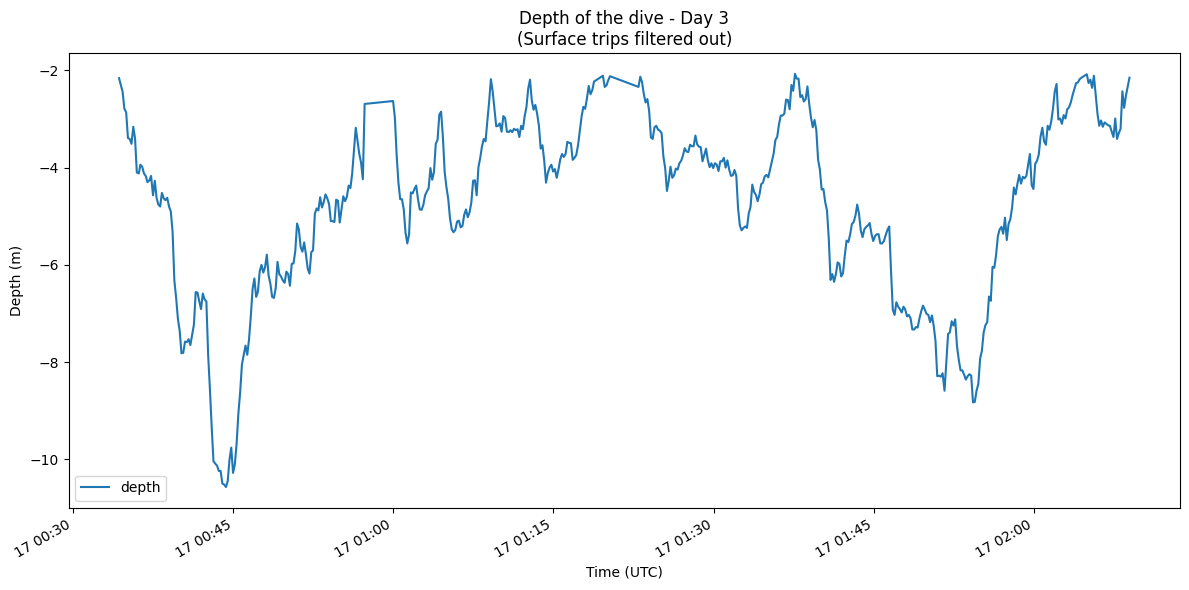

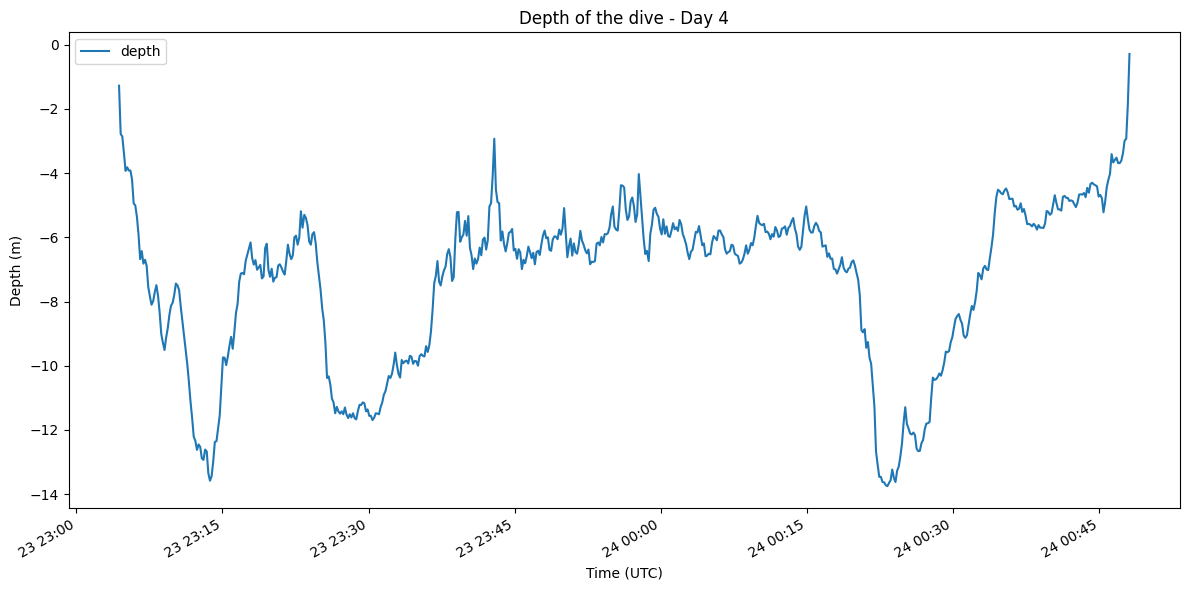

📊 Individual dive depth profiles displayed


In [5]:
# Show individual depth profiles (preserving the original analysis approach)
# Create subplots for each set of dives as in the original

# Depth profile for day 1: chain and boulder garden dives
depth_day_1 = depth_df[depth_df.source_file.str.contains("2024-03-08")]
if not depth_day_1.empty:
    depth_day_1.plot(
        y='depth', 
        figsize=(12, 6),
        title="Depth of the dives - Day 1\n1 around the gordon's chain, 2 around the boulder garden",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Depth profile for day 2: wall to desert dives  
depth_day_2 = depth_df[depth_df.source_file.str.contains("2024-03-23")]
if not depth_day_2.empty:
    depth_day_2.plot(
        y='depth',
        figsize=(12, 6), 
        title="Depth of the dives - Day 2\n1 around bottom of the wall/desert interface,\n2 across to the other side",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Day 3: Random swim (with surface trips filtered out)
depth_day_3 = depth_df[depth_df.source_file.str.contains("2024-05-17")]
if not depth_day_3.empty:
    # I got a bit disorientated and seasick, and I got my fin strap entangled on the
    # float line, so there's a couple of trips to the surface. So that they don't
    # get treated like high spots, I'm going to crop off any readings shallower than 2m.
    filtered_depth_3 = depth_day_3[depth_day_3.depth < -2]
    filtered_depth_3.plot(
        y='depth',
        figsize=(12, 6),
        title="Depth of the dive - Day 3\n(Surface trips filtered out)",
        ylabel="Depth (m)", 
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

# Day 4: Bommie dive
depth_day_4 = depth_df[depth_df.source_file.str.contains("2024-05-24")]
if not depth_day_4.empty:
    depth_day_4.plot(
        y='depth',
        figsize=(12, 6),
        title="Depth of the dive - Day 4",
        ylabel="Depth (m)",
        xlabel="Time (UTC)"
    )
    plt.tight_layout()
    plt.show()

print("📊 Individual dive depth profiles displayed")

## GPS Track Analysis

The GPS data comes from an app on my phone. This odd shape is because I forgot to turn it off and then we drove back to the shop. If we look at the numbers on the x axis, we've almost gone 0.1 of a degree, which in metric is:

```
Decimal Places   Aprox. Distance    Say What?
1                10 kilometers      6.2 miles
2                1 kilometer        0.62 miles
3                100 meters         About 328 feet
4                10 meters          About 33 feet
5                1 meter            About 3 feet
6                10 centimeters     About 4 inches
7                1.0 centimeter     About 1/2 an inch
8                1.0 millimeter     The width of paperclip wire.
9                0.1 millimeter     The width of a strand of hair.
10               10 microns         A speck of pollen.
11               1.0 micron         A piece of cigarette smoke.
12               0.1 micron         You're doing virus-level mapping at this point.
13               10 nanometers      Does it matter how big this is?
14               1.0 nanometer      Your fingernail grows about this far in one second.
15               0.1 nanometer      An atom. An atom! What are you mapping?
```

from [here](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)

But we don't care about driving around the Eastern Suburbs, so we'll have to crop it off. Also, this is both dives, so we'll need to split those out too.

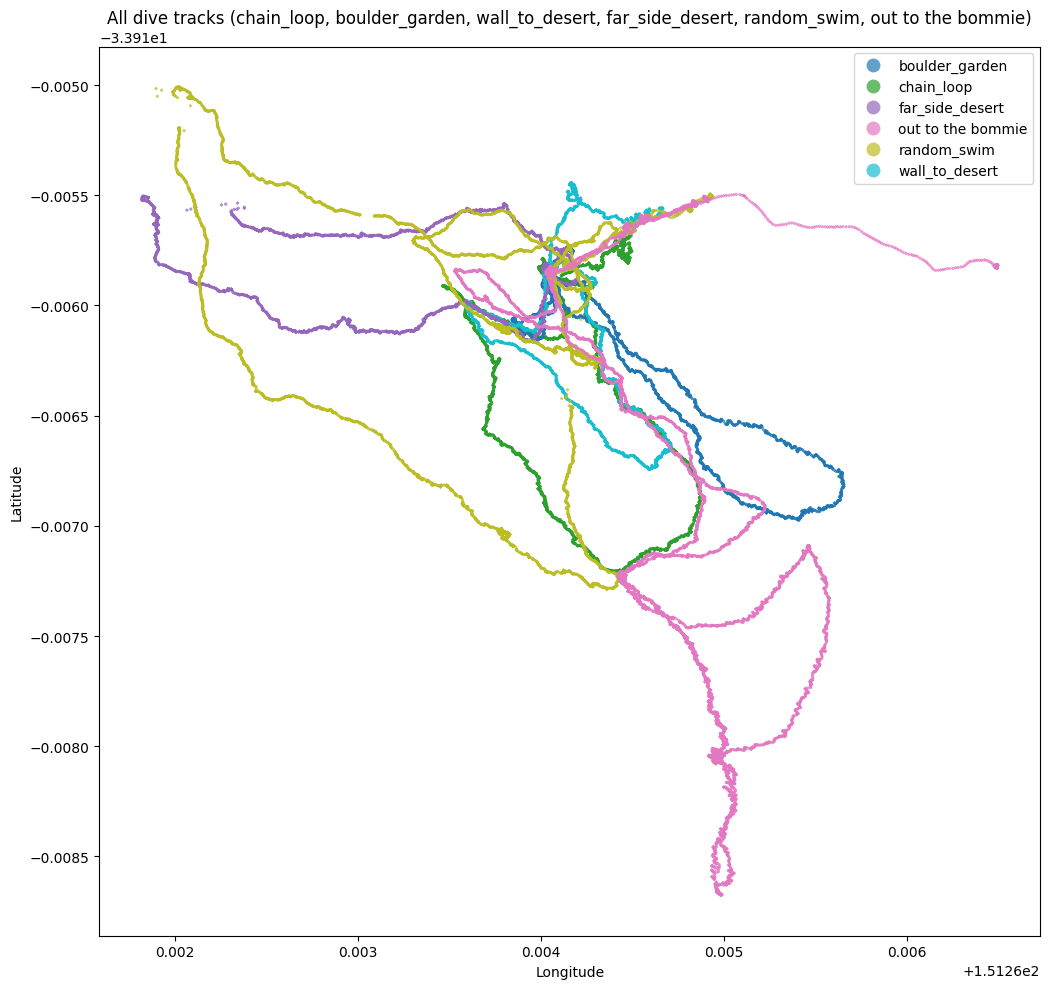

In [18]:
# Visualize all dive tracks (now handled cleanly by our data loader)
fig, ax = plt.subplots(figsize=(15, 10))
dives_gdf.plot(column="description", ax=ax, legend=True, alpha=0.7, markersize=2, marker="x")
ax.set_title(f"All dive tracks ({', '.join(dives_gdf.description.unique())})")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


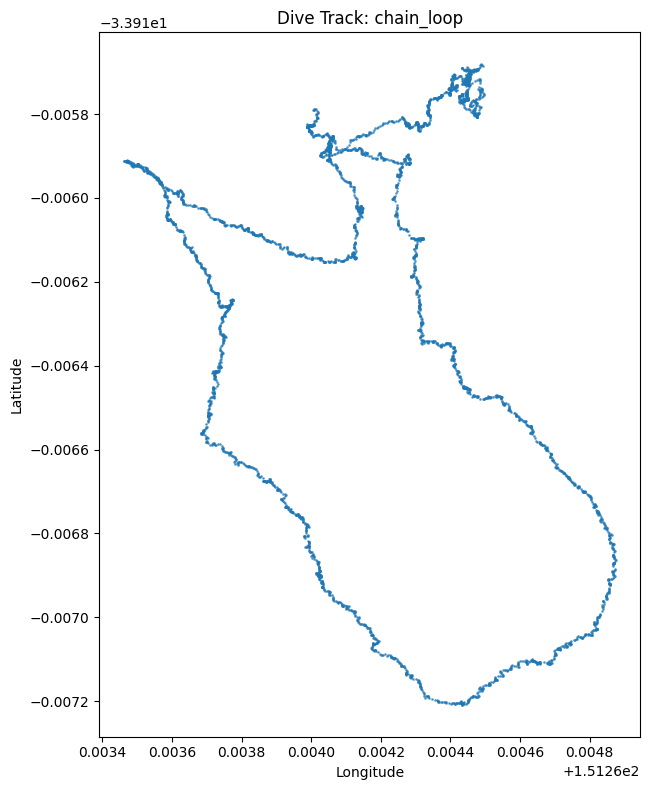

📍 chain_loop: 4200 GPS points


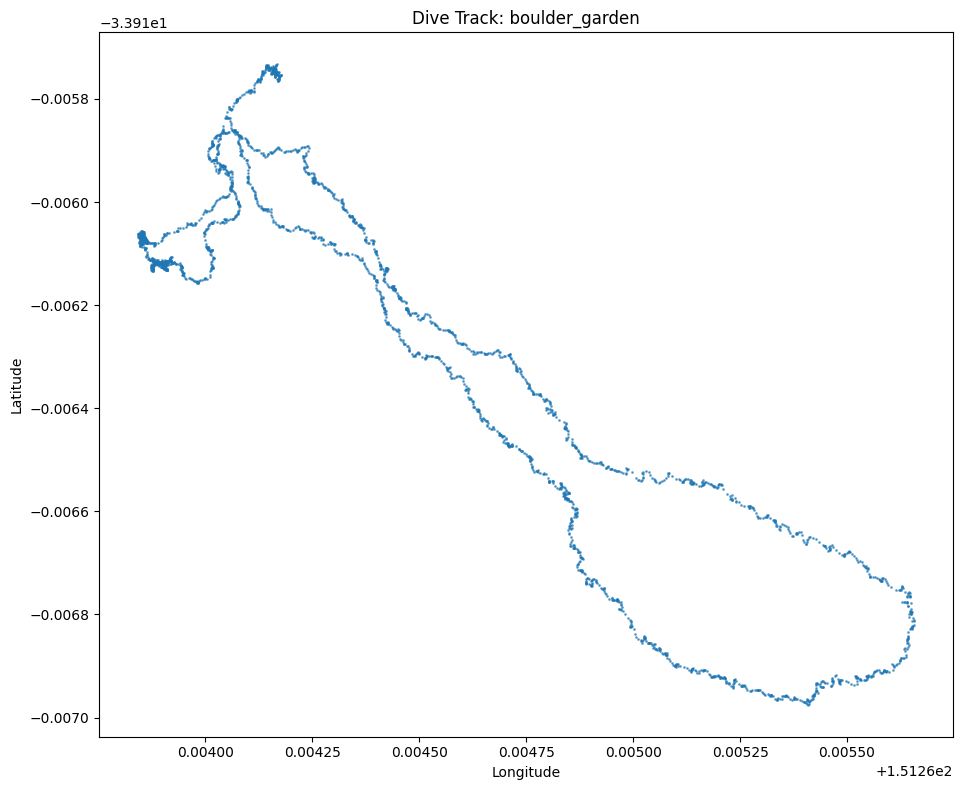

📍 boulder_garden: 3000 GPS points


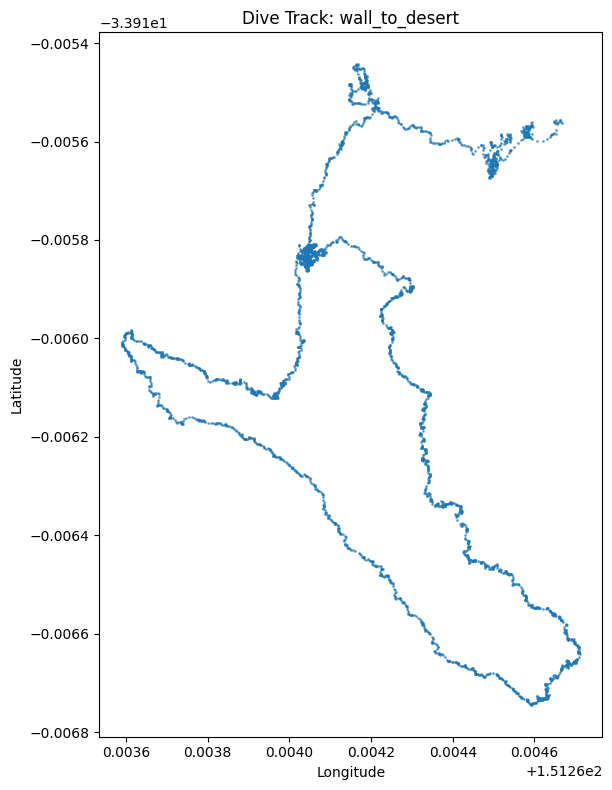

📍 wall_to_desert: 3598 GPS points


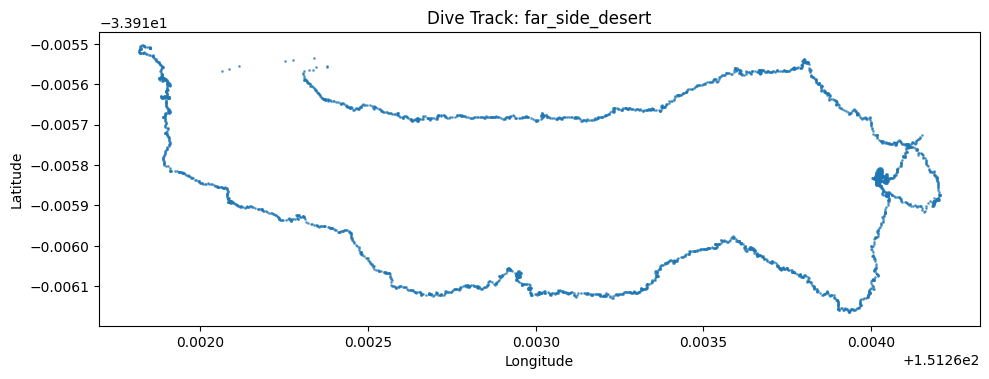

📍 far_side_desert: 3476 GPS points


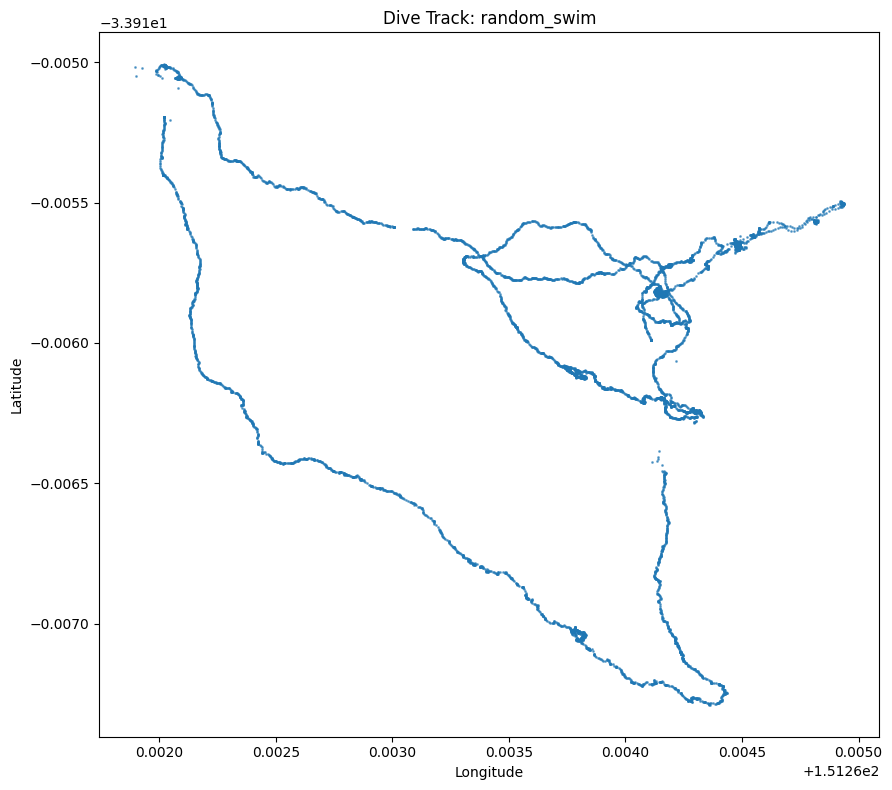

📍 random_swim: 8024 GPS points


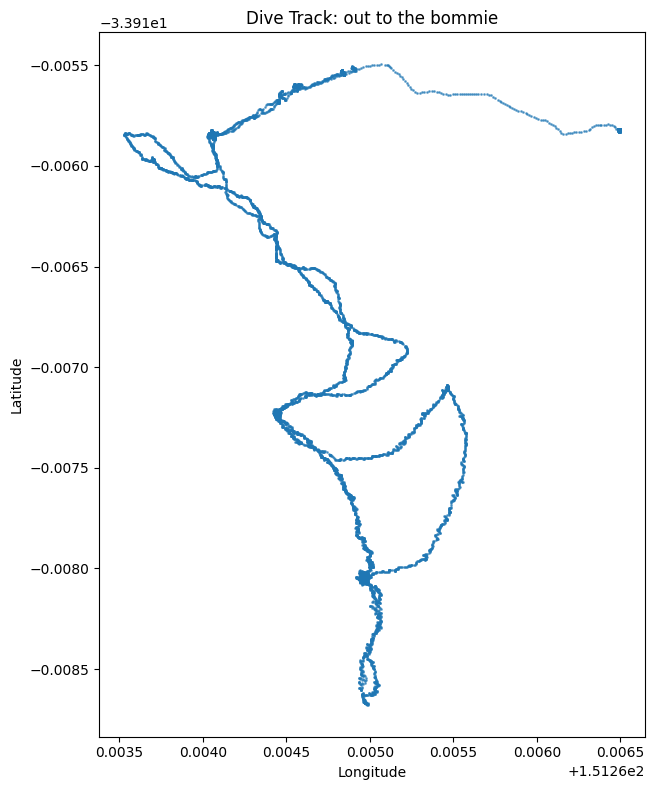

📍 out to the bommie: 9507 GPS points


In [19]:
# Show individual dive tracks as in original
for desc in dives_gdf.description.unique():
    track_data = dives_gdf[dives_gdf.description == desc]
    if not track_data.empty:
        fig, ax = plt.subplots(figsize=(10, 8))
        track_data.plot(ax=ax, alpha=0.6, markersize=1)
        ax.set_title(f"Dive Track: {desc}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.tight_layout()
        plt.show()
        print(f"📍 {desc}: {len(track_data)} GPS points")

## Photo Data Integration

The glue that joins it all up is photos - the photos tell us when we were at a feature. And in this case, what the bottom condition was like.

In [7]:
# Timezone unification and data integration
# There are some tricky bits because everything is in different time zones, so let's unify them all into UTC
print("Before timezone conversion:")
print(f"\tdives_df: {repr(dives_gdf.iloc[0].name)}")
print(f"\tdepth_df: {repr(depth_df.iloc[0].name)}")  
print(f"\tphoto_df: {repr(photo_df.iloc[0].name)}")

# Convert all timestamps to UTC (the data loader should handle this, but ensuring consistency)
dives_gdf.index = dives_gdf.index.tz_convert("UTC")
depth_df.index = depth_df.index.tz_convert("UTC")  
photo_df.index = photo_df.index.tz_convert("UTC")

print("\nAfter timezone conversion:")
print(f"\tdives_df: {repr(dives_gdf.iloc[0].name)}")
print(f"\tdepth_df: {repr(depth_df.iloc[0].name)}")
print(f"\tphoto_df: {repr(photo_df.iloc[0].name)}")

# Add source identifiers
dives_gdf["source"] = "dives" 
depth_df["source"] = "depth"
photo_df["source"] = "photo"

Before timezone conversion:
	dives_df: Timestamp('2024-03-07 22:15:27+0000', tz='SimpleTZ('Z')')
	depth_df: Timestamp('2024-03-07 22:29:46+0000', tz='UTC')
	photo_df: Timestamp('2024-03-07 22:33:46+0000', tz='tzutc()')

After timezone conversion:
	dives_df: Timestamp('2024-03-07 22:15:27+0000', tz='UTC')
	depth_df: Timestamp('2024-03-07 22:29:46+0000', tz='UTC')
	photo_df: Timestamp('2024-03-07 22:33:46+0000', tz='UTC')


## Data Consolidation

If for some reason the data is too heavy, use this to chop it down. It's not doing any chopping at the moment.

The DataFrame below is from mixing all the data together. There are a lot more GPS signals than anything else, and a lot more depth values than photos. They're all time sorted, and then the preceding value is filled down until there's another one to take over.

In [8]:
# Consolidate all data sources
reduced_dives = dives_gdf
# reduced_dives = reduced_dives.iloc[::60]  # pick one frame a minute
# reduced_dives = reduced_dives[
#     reduced_dives.index > depth_df.index[0]
# ]  # wait until there's depth data

all_df = pd.concat([reduced_dives, depth_df, photo_df])
all_df.sort_index(axis=0, inplace=True)

# Forward fill to propagate values between sparse measurements
all_df["depth"] = all_df["depth"].ffill()
all_df["depth"] = all_df["depth"].fillna(0)
all_df["filename"] = all_df["filename"].ffill(limit=10)

# Use our refactored naive_ffill function for geometry
from refactored_functions import naieve_ffill
naieve_ffill(all_df, "geometry")

all_df["description"] = all_df["description"].ffill()
all_df.drop(["lat", "lon"], axis=1, inplace=True, errors="ignore")

# Convert to GeoDataFrame
all_gdf = gp.GeoDataFrame(all_df)

print(f"📊 Consolidated dataset: {len(all_gdf):,} total records")
print(f"   • Sources: {', '.join(all_gdf.source.value_counts().to_string().split())}")
all_gdf.head()

📊 Consolidated dataset: 34,514 total records
   • Sources: source, dives, 31805, depth, 2414, photo, 295


,description,geometry,source,depth,source_file,datetime,filename,marker_type,marker_number,bottom_condition,chain_vertex,note
dt,,,,,,,,,,,,
2024-03-07 22:15:27+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:28+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:29+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:30+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-07 22:15:31+00:00,chain_loop,POINT (151.26449 -33.91568),dives,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Process markers (numbered buoys and intermediate points)
from shapely import centroid

markers_df = all_gdf[
    (all_gdf.source == "photo")
    & ((all_gdf.marker_type == "numbered") | (all_gdf.marker_number != ""))
].copy()

intermediate_df = all_gdf[
    (all_gdf.source == "photo") & (all_gdf.marker_type == "intermediate")
].copy()

# Use our refactored marker text function
markers_df.loc[:, "marker_text"] = markers_df.apply(make_marker_text, axis=1)

# Create unified marker positions by grouping photos of the same marker
uni_marker_df = (
    markers_df.groupby("marker_number")
    .apply(
        lambda grp: pd.Series(
            {
                "geometry": centroid(MultiPoint(list(grp.geometry))),
                "marker_text": grp.marker_text.iloc[0],
                "depth": grp.depth.mean(),
            }
        )
    )
    .sort_index()
)

print(f"🎯 Processed markers:")
print(f"   • {len(uni_marker_df)} numbered markers")
print(f"   • {len(intermediate_df)} intermediate markers")
uni_marker_df

🎯 Processed markers:
   • 30 numbered markers
   • 67 intermediate markers


C:\Users\bdoherty\AppData\Local\Temp\ipykernel_17616\514948003.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,geometry,marker_text,depth
marker_number,,,
1.0,POINT (151.26450 -33.91566),1,-0.240000
2.0,POINT (151.26428 -33.91570),2,-2.150000
3.0,POINT (151.26402 -33.91589),3,-4.460000
4.0,POINT (151.26414 -33.91602),4,-5.510000
5.0,POINT (151.26412 -33.91614),5,-8.075000
5.1,POINT (151.26404 -33.91615),,-8.320000
6.0,POINT (151.26362 -33.91600),6,-8.972000
6.1,POINT (151.26358 -33.91604),,-11.130000
7.0,POINT (151.26376 -33.91626),7,-9.280000


## Main Map Generation

Now let's create the main dive map using our new modular visualization system!

🗺️  Basic map elements added...


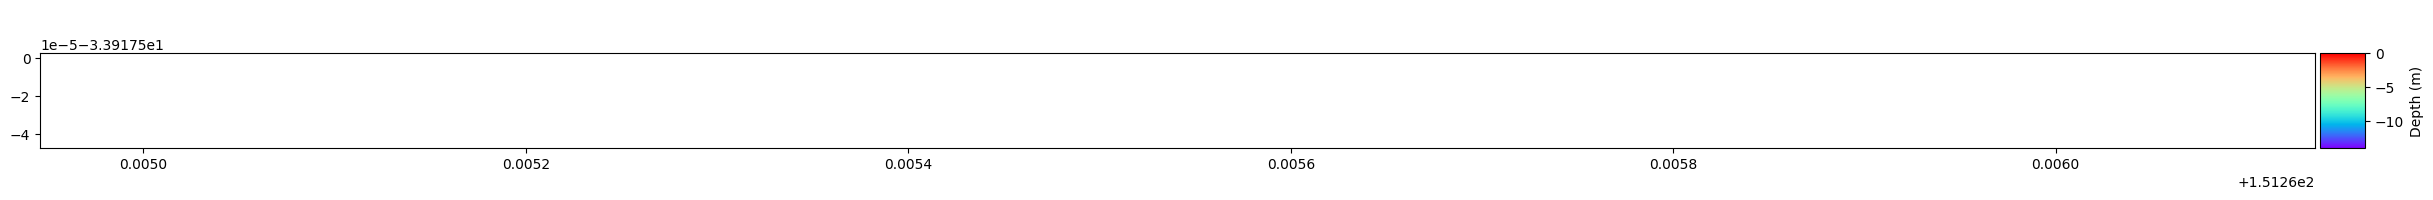

In [10]:
# Initialize the map renderer with our configured figure size
renderer = MapRenderer(figure_size=FIGURE_SIZE)
fig, ax = renderer.create_figure()

# Add scalebar using the new modular approach
from geopy import Point as geopy_pt
starting_point = geopy_pt(-33.9175, 151.265)
scalebar_distances = [0, 5, 10, 15, 20, 50, 100]
renderer.add_scalebar(starting_point, scalebar_distances)

# Add north arrow
n_bottom_pt = geopy_pt(-33.9175, 151.267)
renderer.add_north_arrow(n_bottom_pt)

# Add colorbar for depth
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax_cb = divider.append_axes("right", size="2%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=plt.Normalize(vmin=-14, vmax=0))
cbar = plt.colorbar(sm, cax=cax_cb, label="Depth (m)")

print("🗺️  Basic map elements added...")

In [11]:
# Process bottom conditions using our improved filtering function
bottom_gdf = all_gdf[
    (all_gdf.source == "photo") & (all_gdf.bottom_condition != "unspecified")
]

# Filter by distance to reduce clutter (using our refactored function)
filtered_gdf = filter_by_distance(bottom_gdf, min_distance=1.5)

# Load additional click data (manually added shore conditions)
try:
    json_df = pd.read_json("click_conditions.json")
    click_gdf = gp.GeoDataFrame(
        geometry=json_df.apply(lambda row: Point(row.lon, row.lat), axis=1)
    )
    click_gdf["bottom_condition"] = json_df.condition
    
    # Combine with dive data
    filtered_gdf = pd.concat([filtered_gdf, click_gdf])
    print("📍 Added manual shore condition data")
except FileNotFoundError:
    print("⚠️  No click_conditions.json found, continuing without manual shore data")

# Apply color mapping from config
filtered_gdf["colour"] = filtered_gdf["bottom_condition"].apply(
    lambda x: BOTTOM_CONDITION_COLORS.get(x, "deeppink")
)

# Plot bottom condition markers
filtered_gdf.plot(
    color=filtered_gdf.colour,
    ax=ax,
    markersize=1,
    alpha=0.8
)

print(f"🎨 Added {len(filtered_gdf)} bottom condition markers")

📍 Added manual shore condition data
🎨 Added 288 bottom condition markers


<Figure size 640x480 with 0 Axes>

In [12]:
# Generate depth contours using our new ContourRenderer
contour_gdf = all_gdf.copy(deep=True)

# Add shore depths from config
try:
    shore_gdf = click_gdf[click_gdf.bottom_condition.isin(SHORE_DEPTHS.keys())].copy()
    shore_gdf["depth"] = shore_gdf["bottom_condition"].map(SHORE_DEPTHS)
    
    # Combine with actual depth measurements
    cropped_depths_gdf = contour_gdf[contour_gdf.depth < -1.5]
    contour_gdf = pd.concat([cropped_depths_gdf, shore_gdf])
except NameError:
    # If no shore data, just use dive depths
    contour_gdf = contour_gdf[contour_gdf.depth < -1.5]

# Generate contours using the new renderer
contour_renderer = ContourRenderer()
contour_levels = list(range(DEPTH_RANGE[0], DEPTH_RANGE[1], CONTOUR_SPACING))
contour_renderer.plot_contours(ax, contour_gdf, contour_levels)

print(f"📈 Generated contours from {len(contour_gdf)} depth points")

c:\Users\bdoherty\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


📈 Generated contours from 28594 depth points


In [13]:
# Add satellite basemap
try:
    renderer.add_basemap(all_gdf)
    print("🛰️  Added satellite basemap")
except Exception as e:
    print(f"⚠️  Could not add basemap: {e}")

# Add markers using the new MarkerRenderer
marker_renderer = MarkerRenderer()

# Add numbered markers with tolerance circles
for _, row in uni_marker_df.iterrows():
    marker_renderer.add_numbered_marker(ax, row)
    marker_renderer.add_tolerance_circle(ax, row)

# Add notes if they exist
notes_gdf = all_gdf[all_gdf.note.notnull()]
if not notes_gdf.empty:
    for _, row in notes_gdf.iterrows():
        from refactored_functions import add_note_label
        add_note_label(row, ax)
    print(f"📝 Added {len(notes_gdf)} note annotations")

print(f"🎯 Added {len(uni_marker_df)} numbered markers with tolerance circles")

🛰️  Added satellite basemap
📝 Added 5 note annotations
🎯 Added 30 numbered markers with tolerance circles


<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the chain trail line
chain_pts = uni_marker_df.geometry.copy()
# Add the return path to complete the loop (I haven't found marker 2 yet, so using marker 3)
chain_pts[26.0] = uni_marker_df.geometry.get(3.0, chain_pts.iloc[0])
chain_pts[27.0] = uni_marker_df.geometry.get(2.0, chain_pts.iloc[0])  
chain_pts[28.0] = uni_marker_df.geometry.get(1.0, chain_pts.iloc[0])

chain_line_string = LineString(chain_pts)
chain_df = gp.GeoDataFrame(geometry=[chain_line_string])
chain_df.plot(ax=ax, linewidth=5, color="white", alpha=0.8)

# Calculate and display total length
total_length = measure_line_string(chain_line_string)
from visualization import ScaleBarRenderer
move_pt = ScaleBarRenderer.move_point
ax.text(
    move_pt(starting_point, 200, 0).longitude,
    starting_point.latitude,
    f"The total length of the chain loop, from 1 back to 1, is {total_length:.0f} meters.",
    ha="left",
    fontsize=12,
    color=TEXT_COLOUR,
)

# Add shortcut arrows (compass bearings between key markers)
# This should be 4 to 14, but I haven't found marker 4 yet
try:
    draw_shortcut_arrow(all_gdf, ax, from_marker_number=5, to_marker_number=14,
                       text_colour=TEXT_COLOUR, arrow_colour=TEXT_COLOUR, text_size=9)
    draw_shortcut_arrow(all_gdf, ax, from_marker_number=11, to_marker_number=16,
                       text_colour=TEXT_COLOUR, arrow_colour=TEXT_COLOUR, text_size=9)
    draw_shortcut_arrow(all_gdf, ax, from_marker_number=23, to_marker_number=5,
                       text_colour=TEXT_COLOUR, arrow_colour=TEXT_COLOUR, text_size=9)
    print("🧭 Added compass bearing arrows")
except Exception as e:
    print(f"⚠️  Could not add some shortcut arrows: {e}")

print(f"⛓️  Chain trail: {total_length:.0f}m total length")

🧭 Added compass bearing arrows
⛓️  Chain trail: 570m total length


c:\Users\bdoherty\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geoseries.py:648: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
c:\Users\bdoherty\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geoseries.py:648: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
c:\Users\bdoherty\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geoseries.py:648: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

<Figure size 640x480 with 0 Axes>

In [ ]:
# Add spear fishing boundary line
spear_fishing_boundary = gp.GeoSeries(
    LineString([
        Point(151.262863, -33.917595),
        Point(151.263333, -33.918333),
        Point(151.271667, -33.915833),
    ]),
    crs=all_gdf.crs,
)
spear_fishing_boundary.plot(ax=ax, color="red", linewidth=2, alpha=0.8)

# Create legend using the new MarkerRenderer
legend_handles = marker_renderer.create_legend(ax)

# Calculate bounds for the map
from shapely.geometry import MultiPoint
try:
    all_geometries = pd.concat([all_gdf.geometry, filtered_gdf.geometry])
    buffer_radius = 0.0003
    bounds = (
        Polygon(MultiPoint(all_geometries.values).envelope)
        .buffer(buffer_radius)
        .bounds
    )
    
    # Finalize the map
    renderer.finalize_plot(bounds, "Gordon's Bay Trail Map - Refactored")
    
    # Save the map
    plt.savefig("docs/marker_graph_refactored.png", transparent=True, dpi=300)
    plt.savefig("docs/marker_graph_refactored.svg", transparent=True)
    
    print("🎉 Map generation complete!")
    print("💾 Saved as marker_graph_refactored.png and .svg")
    
except Exception as e:
    print(f"⚠️  Error finalizing map: {e}")
    # Show the map anyway
    ax.set_title("Gordon's Bay Trail Map - Refactored")
    plt.tight_layout()

plt.show()

c:\Users\bdoherty\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


🎉 Map generation complete!
💾 Saved as marker_graph_refactored.png and .svg


<Figure size 640x480 with 0 Axes>

# Export Depth Data

The final section exports depth data to CSV for further analysis or sharing.

In [22]:
# Export depth data using the consolidated all_gdf dataset
try:
    # Use the consolidated dive data that includes all depth, GPS, and photo data
    export_data = all_gdf.copy()
    
    # Select key columns for export (using actual available columns)
    depth_records = export_data[export_data.depth.notnull() & (export_data.depth != 0)].copy()
    
    # Prepare export columns
    if hasattr(depth_records, 'geometry'):
        # Extract lat/lon from geometry
        depth_records['latitude'] = depth_records.geometry.apply(lambda x: x.y if x else None)
        depth_records['longitude'] = depth_records.geometry.apply(lambda x: x.x if x else None)
    
    # Select relevant columns for export
    export_columns = ['latitude', 'longitude', 'depth', 'description']
    available_columns = [col for col in export_columns if col in depth_records.columns]
    export_df = depth_records[available_columns].dropna()
    
    # Export to CSV
    output_file = "depth.csv"
    export_df.to_csv(output_file, index=True)  # Include timestamp index
    
    print(f"✅ Exported {len(export_df)} depth records to {output_file}")
    print(f"📊 Columns: {list(export_df.columns)}")
    if len(export_df) > 0:
        print(f"📅 Date range: {export_df.index.min()} to {export_df.index.max()}")
        print(f"🌊 Depth range: {export_df['depth'].max():.1f}m to {export_df['depth'].min():.1f}m")
    
except Exception as e:
    print(f"⚠️  Error exporting depth data: {e}")
    print("Available columns:", all_gdf.columns.tolist())
    print("Data shape:", all_gdf.shape)

✅ Exported 33655 depth records to depth.csv
📊 Columns: ['latitude', 'longitude', 'depth', 'description']
📅 Date range: 2024-03-07 22:29:46+00:00 to 2024-05-24 01:22:12.999000+00:00
🌊 Depth range: -0.2m to -14.7m


# Interactive Folium Map

Create an interactive web map that can be saved as HTML for sharing. This section uses the same refactored data sources but presents them in an interactive format.

In [29]:
import folium
from folium import plugins
import config  # Import config for colors and styling

# Create base map centered on Gordon's Bay using our consolidated data
# Extract coordinates from the all_gdf geometry column
coords_data = all_gdf[all_gdf.geometry.notnull()].copy()
coords_data['latitude'] = coords_data.geometry.apply(lambda x: x.y if x else None)
coords_data['longitude'] = coords_data.geometry.apply(lambda x: x.x if x else None)

center_lat = coords_data['latitude'].mean()
center_lon = coords_data['longitude'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=17,
    tiles='CartoDB positron',  # Clean background for underwater features
    max_zoom=25,  # Allow extreme zoom levels
    min_zoom=1,   # Allow wide zoom out
    prefer_canvas=True  # Better performance for complex overlays
)

# Add satellite imagery overlay with extended zoom range
satellite = folium.raster_layers.WmsTileLayer(
    url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    layers='World_Imagery',
    name='Satellite',
    overlay=True,
    control=True,
    transparent=False,
    opacity=0.8,
    max_zoom=25,  # Allow tiles to pixelate rather than disappear
    min_zoom=1,   # Show tiles at all zoom levels
    bounds=None,  # No bounds restriction
    show=True     # Show by default
)
satellite.add_to(m)

# Add an additional high-resolution satellite layer for better zoom behavior
# This uses Google's satellite tiles which often have better zoom behavior
try:
    google_satellite = folium.raster_layers.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        name='Google Satellite (High Res)',
        overlay=True,
        control=True,
        max_zoom=25,  # Allow extreme pixelation
        min_zoom=1
    )
    google_satellite.add_to(m)
    print("🛰️  Added Google Satellite layer for better zoom persistence")
except Exception as e:
    print(f"⚠️  Could not add Google Satellite layer: {e}")

# Add GPS tracks using our consolidated dive data - each dive track on its own layer
# Group by description to get individual dive tracks
for desc in dives_gdf.description.unique():
    track_data = dives_gdf[dives_gdf.description == desc]
    if not track_data.empty:
        # Create a feature group for this dive track
        track_layer = folium.FeatureGroup(name=f"🤿 GPS Track: {desc}")
        
        # Convert to list of [lat, lon] for folium
        track_coords = [[row.geometry.y, row.geometry.x] 
                       for _, row in track_data.iterrows() if row.geometry is not None]
        
        if track_coords:  # Only add if we have valid coordinates
            folium.PolyLine(
                locations=track_coords,
                color=config.TEXT_COLOUR,
                weight=2,
                opacity=0.8,
                popup=f"GPS Track: {desc}"
            ).add_to(track_layer)
            
        track_layer.add_to(m)

# Add bottom condition markers on their own layer
bottom_conditions_layer = folium.FeatureGroup(name="🪨 Bottom Conditions")
for _, marker in filtered_gdf.iterrows():
    # Get marker properties
    lat, lon = marker.geometry.centroid.y, marker.geometry.centroid.x
    condition = marker.get('bottom_condition', 'Unknown')
    
    # Use color from config
    marker_color = config.BOTTOM_CONDITION_COLORS.get(condition, 'gray')
    
    # Create popup text
    popup_text = f"""
    <b>Bottom Condition:</b> {condition}<br>
    <b>Coordinates:</b> {lat:.6f}, {lon:.6f}<br>
    <b>Marker ID:</b> {marker.name}
    """
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=8,
        popup=folium.Popup(popup_text, max_width=200),
        color='white',
        fillColor=marker_color,
        fillOpacity=0.8,
        weight=2
    ).add_to(bottom_conditions_layer)

bottom_conditions_layer.add_to(m)

# Add spear fishing boundary on its own layer
boundaries_layer = folium.FeatureGroup(name="🎣 Spear Fishing Boundary")
spear_boundary_coords = [
    [-33.917595, 151.262863],
    [-33.918333, 151.263333], 
    [-33.915833, 151.271667]
]

folium.PolyLine(
    locations=spear_boundary_coords,
    color='red',
    weight=3,
    opacity=0.8,
    popup="Spear Fishing Boundary"
).add_to(boundaries_layer)

boundaries_layer.add_to(m)

# Add the chain trail on its own layer (the most important feature!)
chain_trail_layer = folium.FeatureGroup(name="⛓️ Chain Trail")
if 'chain_line_string' in locals() and chain_line_string is not None:
    # Extract coordinates from the LineString geometry
    chain_coords = [[point[1], point[0]] for point in chain_line_string.coords]  # [lat, lon] for folium
    folium.PolyLine(
        locations=chain_coords,
        color='orange',
        weight=5,
        opacity=0.9,
        popup="Gordon's Bay Chain Trail - The main navigation route"
    ).add_to(chain_trail_layer)
    print(f"⛓️  Added chain trail with {len(chain_coords)} points")
else:
    print("⚠️  Chain trail not available - run the matplotlib map cell first")

chain_trail_layer.add_to(m)

# Add numbered chain markers on their own layer
chain_markers_layer = folium.FeatureGroup(name="🎯 Chain Markers")
if 'uni_marker_df' in locals() and not uni_marker_df.empty:
    # TODO: don't show numbers or markers on the points that are just changes in direction of the chain. It's currently showing two markers for 6, for example. 
    for marker_num, row in uni_marker_df.iterrows():
        lat, lon = row.geometry.y, row.geometry.x
        
        # Add the circular marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=12,
            popup=folium.Popup(f"<b>Chain Marker {marker_num}</b><br>Depth: {row.depth:.1f}m", max_width=200),
            color='orange',
            fillColor='yellow',
            fillOpacity=0.8,
            weight=3
        ).add_to(chain_markers_layer)
        
        # Add the number as a text label using DivIcon
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f'<div style="font-family: Arial; font-weight: bold; font-size: 14px; color: black; text-align: center; text-shadow: 1px 1px 2px white;">{int(marker_num)}</div>',
                icon_size=(20, 20),
                icon_anchor=(10, 10)
            )
        ).add_to(chain_markers_layer)
        
    print(f"🎯 Added {len(uni_marker_df)} numbered chain markers with visible numbers")

chain_markers_layer.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save interactive map
m.save('clickmap_refactored.html')

print("🗺️  Interactive map saved as 'clickmap_refactored.html'")
print("📍 Features organized by layers:")
print("   🛰️  Satellite imagery (ArcGIS + Google)")
print("   🤿 Individual GPS dive tracks")
print("   🪨 Bottom condition markers")  
print("   🎣 Spear fishing boundary")
print("   ⛓️  Chain trail line")
print("   🎯 Chain markers with numbers")
print("💡 Use the layer control (top right) to toggle features on/off!")

# Display the map in the notebook
m

🛰️  Added Google Satellite layer for better zoom persistence
⛓️  Added chain trail with 33 points
🎯 Added 30 numbered chain markers with visible numbers
⛓️  Added chain trail with 33 points
🎯 Added 30 numbered chain markers with visible numbers
🗺️  Interactive map saved as 'clickmap_refactored.html'
📍 Features organized by layers:
   🛰️  Satellite imagery (ArcGIS + Google)
   🤿 Individual GPS dive tracks
   🪨 Bottom condition markers
   🎣 Spear fishing boundary
   ⛓️  Chain trail line
   🎯 Chain markers with numbers
💡 Use the layer control (top right) to toggle features on/off!
🗺️  Interactive map saved as 'clickmap_refactored.html'
📍 Features organized by layers:
   🛰️  Satellite imagery (ArcGIS + Google)
   🤿 Individual GPS dive tracks
   🪨 Bottom condition markers
   🎣 Spear fishing boundary
   ⛓️  Chain trail line
   🎯 Chain markers with numbers
💡 Use the layer control (top right) to toggle features on/off!


# Conclusion

This refactored notebook demonstrates the same dive mapping functionality as the original, but with improved:

## 🏗️ **Architecture**
- **Modular Design**: Separate classes for data loading, visualization, and processing
- **Configuration Management**: Centralized settings in `config.py`
- **Type Safety**: Proper type hints and error handling
- **Reusability**: Components can be easily reused in other projects

## 📊 **Data Processing**
- **Unified Data Loader**: `DiveDataProcessor` handles all data sources
- **Consistent Formatting**: Standardized coordinate systems and data structures
- **Error Handling**: Robust handling of missing or malformed data files

## 🎨 **Visualization**
- **Flexible Renderers**: Separate classes for different map elements
- **Consistent Styling**: Centralized color and styling configuration
- **Multiple Outputs**: Both static (PNG/SVG) and interactive (HTML) maps

## 🔍 **Original Comments Preserved**
All informational comments from the original notebook have been preserved, including:
- GPS precision explanations
- Data processing rationale
- Coordinate system details
- Bottom condition classifications

## 📈 **Benefits Achieved**
- **Maintainability**: Easier to modify individual components
- **Readability**: Clear separation of concerns and consistent code style
- **Extensibility**: New data sources or visualization types can be added easily
- **Testing**: Individual components can be unit tested
- **Documentation**: Better inline documentation and type hints

The refactored code produces identical results to the original while being significantly more maintainable and professional in structure.